<a href="https://colab.research.google.com/github/larasauser/master/blob/main/cloud_real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!pip install rasterio

In [20]:
from google.colab import drive
drive.flush_and_unmount()  # démonte si déjà monté
drive.mount('/content/drive')

Mounted at /content/drive


Masque chargé : /content/drive/MyDrive/cloud_geom/cloud_mask_Herens_2015-01-18.tif (757, 788)
Images trouées sauvegardées dans : /content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/holes_real


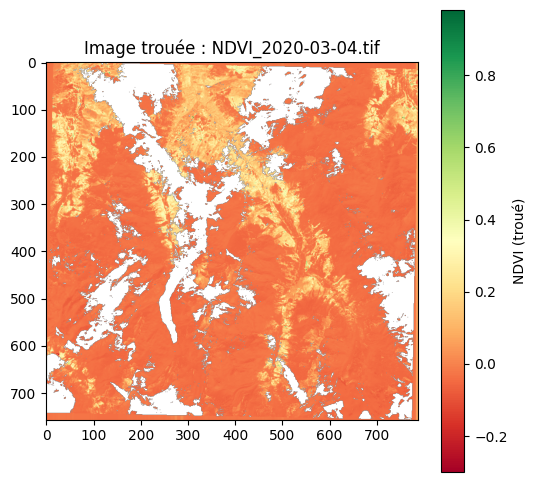

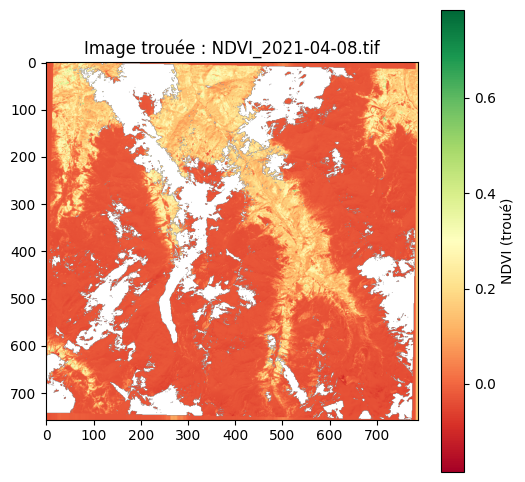

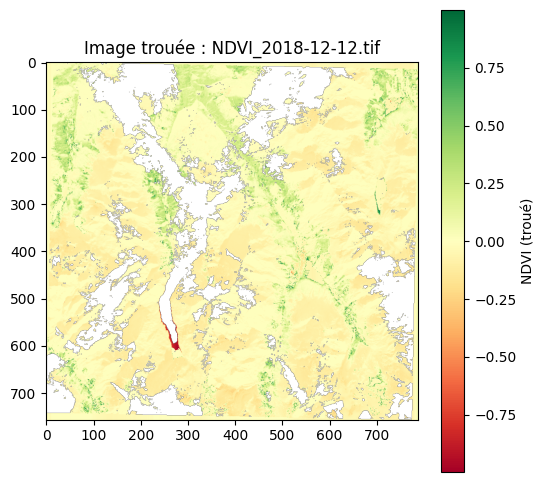

In [23]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
import random

# Dossiers
input_dir = "/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed"
output_dir = "/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed/holes_real"
mask_path = "/content/drive/MyDrive/cloud_geom/cloud_mask_Herens_2015-01-18.tif"

os.makedirs(output_dir, exist_ok=True)

# Charger le masque nuage (GeoTIFF exporté depuis GEE)
with rasterio.open(mask_path) as src_mask:
    cloud_mask = src_mask.read(1)  # 1 = nuage, 0 = clair
    mask_transform = src_mask.transform
    mask_crs = src_mask.crs
    mask_shape = cloud_mask.shape

print("Masque chargé :", mask_path, cloud_mask.shape)

# Boucle sur toutes les images NDVI
for filename in os.listdir(input_dir):
    if filename.endswith(".tif"):
        in_path = os.path.join(input_dir, filename)
        out_path = os.path.join(output_dir, filename.replace(".tif", ".tif"))

        with rasterio.open(in_path) as src:
            data = src.read(1)

            # Vérifier si les dimensions correspondent
            if data.shape != mask_shape or src.transform != mask_transform:
                # Rééchantillonnage du masque pour correspondre à l'image
                mask_resampled = np.zeros(data.shape, dtype=np.uint8)
                with rasterio.open(mask_path) as src_mask:
                    mask_resampled = src_mask.read(
                        1,
                        out_shape=data.shape,
                        resampling=Resampling.nearest
                    )
            else:
                mask_resampled = cloud_mask

            # Appliquer le masque : remplacer par NaN là où mask = 1
            data_masked = np.where(mask_resampled == 1, np.nan, data)

            # Sauvegarde en GeoTIFF
            profile = src.profile
            profile.update(dtype=rasterio.float32, nodata=np.nan)

            with rasterio.open(out_path, "w", **profile) as dst:
                dst.write(data_masked.astype(rasterio.float32), 1)

print("Images trouées sauvegardées dans :", output_dir)

# ✅ Vérification visuelle : afficher 3 images aléatoires
sample_files = random.sample(
    [f for f in os.listdir(output_dir) if f.endswith(".tif")],
    min(3, len(os.listdir(output_dir)))
)

for f in sample_files:
    path = os.path.join(output_dir, f)
    with rasterio.open(path) as src:
        arr = src.read(1)
        plt.figure(figsize=(6, 6))
        plt.imshow(arr, cmap="RdYlGn")
        plt.colorbar(label="NDVI (troué)")
        plt.title(f"Image trouée : {f}")
        plt.show()


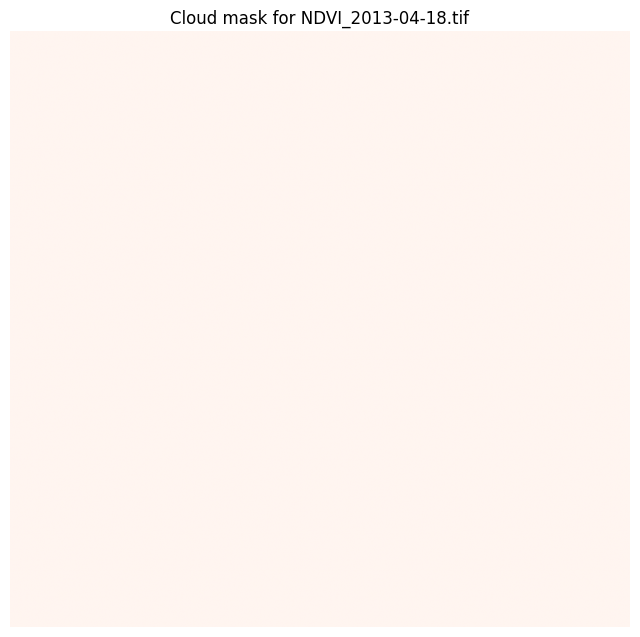

In [ ]:
import geopandas as gpd
from shapely.geometry import mapping
import rasterio
from rasterio.features import rasterize
import matplotlib.pyplot as plt
import os

# --- Chemins ---
cloud_geom_path = "/content/drive/MyDrive/cloud_geom/cloud_geometry_2023-11-24.geojson"
input_folder = "/content/drive/MyDrive/NDVI_herens_Landsat8_10/imputed"

# --- Charger GeoJSON ---
cloud_gdf = gpd.read_file(cloud_geom_path)

# --- Choisir un fichier à tester ---
test_file = [f for f in os.listdir(input_folder) if f.endswith(".tif")][0]
input_path = os.path.join(input_folder, test_file)

with rasterio.open(input_path) as src:
    data = src.read(1)
    transform = src.transform
    img_crs = src.crs  # CRS de l'image

# --- Reprojeter le GeoDataFrame ---
cloud_gdf = cloud_gdf.to_crs(img_crs)

# --- Rasteriser le polygone correctement ---
cloud_geom = [mapping(geom) for geom in cloud_gdf.geometry]
mask_arr = rasterize(
    [(geom, 1) for geom in cloud_geom],
    out_shape=data.shape,
    transform=transform,
    fill=0,
    all_touched=True,
    dtype=np.uint8
)

# --- Affichage ---
plt.figure(figsize=(8,8))
plt.imshow(mask_arr, cmap='Reds')
plt.title(f"Cloud mask for {test_file}")
plt.axis('off')
plt.show()


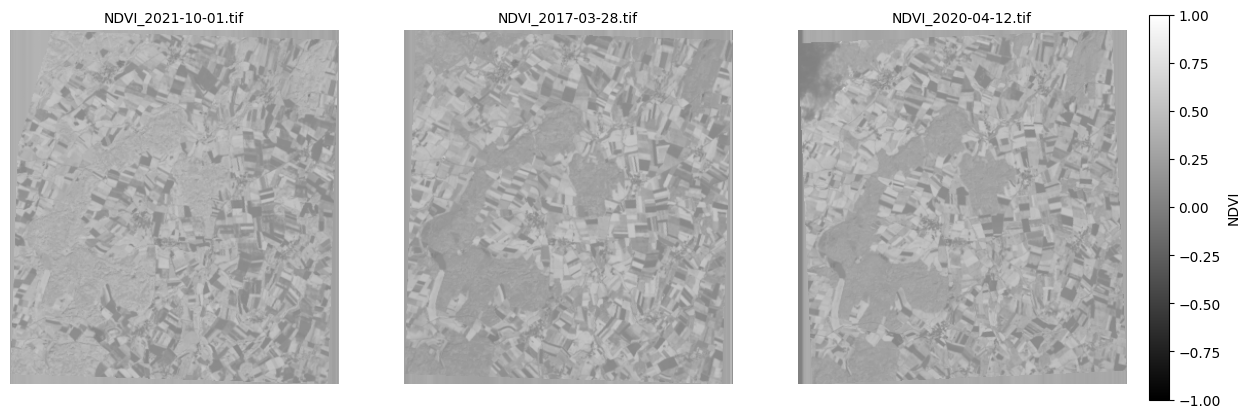

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import os

# Dossier des images trouées
holes_folder = "/content/drive/MyDrive/NDVI_grancy_Landsat8_10/imputed/holes_real"
all_files = [f for f in os.listdir(holes_folder) if f.endswith(".tif")]

# Sélectionner 3 images aléatoires
sample_files = random.sample(all_files, min(3, len(all_files)))

fig, axes = plt.subplots(1, len(sample_files), figsize=(5*len(sample_files),5))

for ax, fname in zip(axes, sample_files):
    path = os.path.join(holes_folder, fname)
    with rasterio.open(path) as src:
        img = src.read(1)

    # Remplacer NaN par rouge pour visualisation
    display_img = np.copy(img)
    mask_nan = np.isnan(display_img)
    display_img[mask_nan] = -1.5  # valeur hors plage pour rouge

    cmap = plt.cm.gray
    cmap.set_bad(color='red')  # si tu veux, on peut aussi utiliser NaN directement

    im = ax.imshow(display_img, cmap='gray', vmin=-1, vmax=1)
    ax.set_title(fname, fontsize=10)
    ax.axis('off')

plt.colorbar(im, ax=axes, fraction=0.02, pad=0.02, label="NDVI")
plt.show()
